<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 5 columns):
name             3933 non-null object
address          3933 non-null object
age              3933 non-null int64
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: int64(1), object(4)
memory usage: 184.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 21 columns):
name                3983 non-null object
address             3983 non-null object
kurtosis_oxygen     3709 non-null object
occupation          3974 non-null object
pregnant            3967 non-null object
education-num       3964 non-null float64
skewness_glucose    3970 non-null float64
mean_glucose        3573 non-null float64
std_oxygen          3967 non-null float64
capital-gain        3970 non-null float64
skewness_oxygen     3969 non-null float64
kurtosis_glucose    3965 non-null float64
personal_info       3968 non-null object
fnlwgt

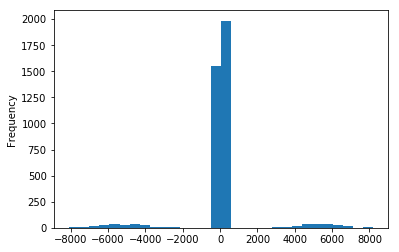

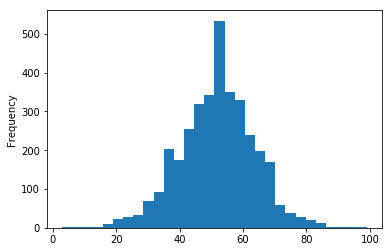

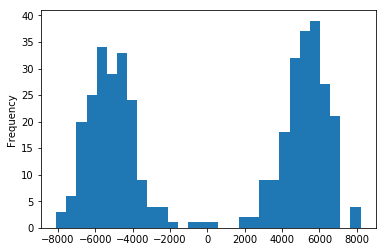

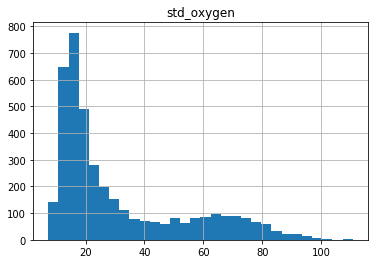

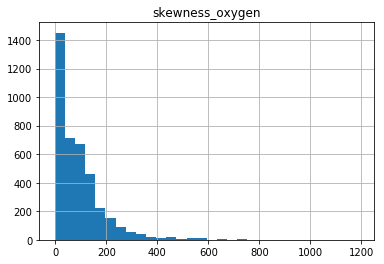

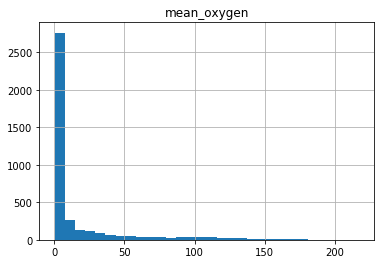

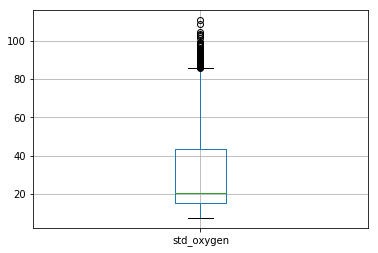

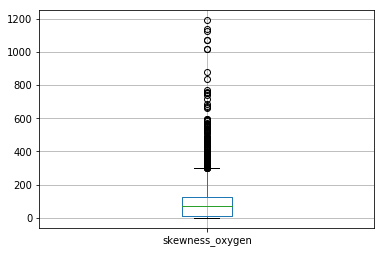

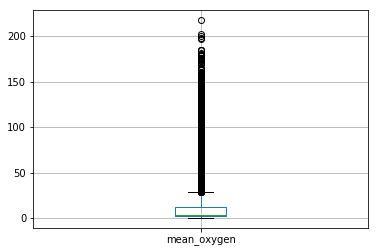

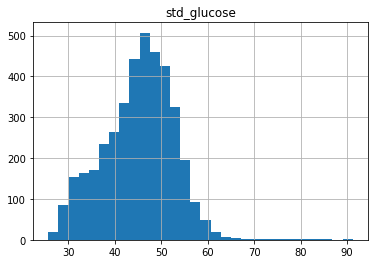

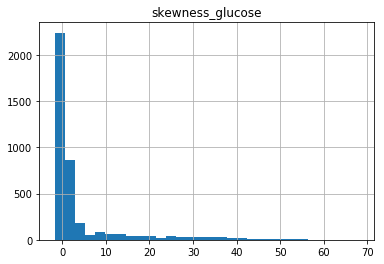

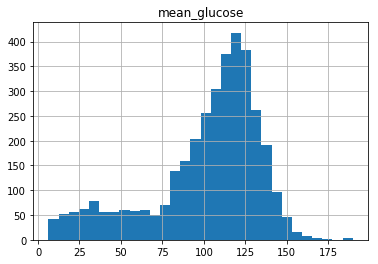

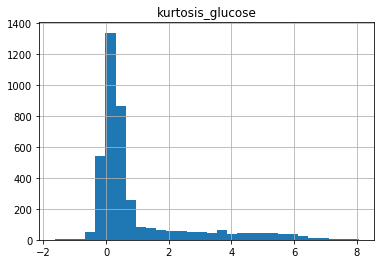

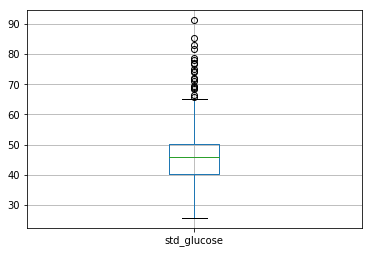

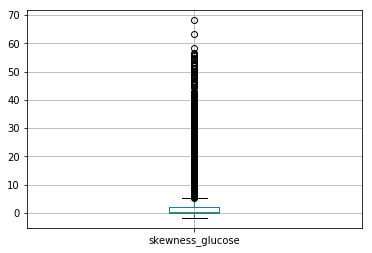

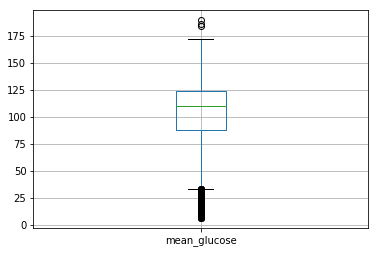

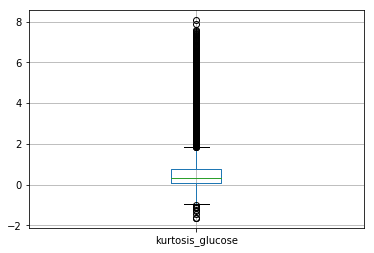

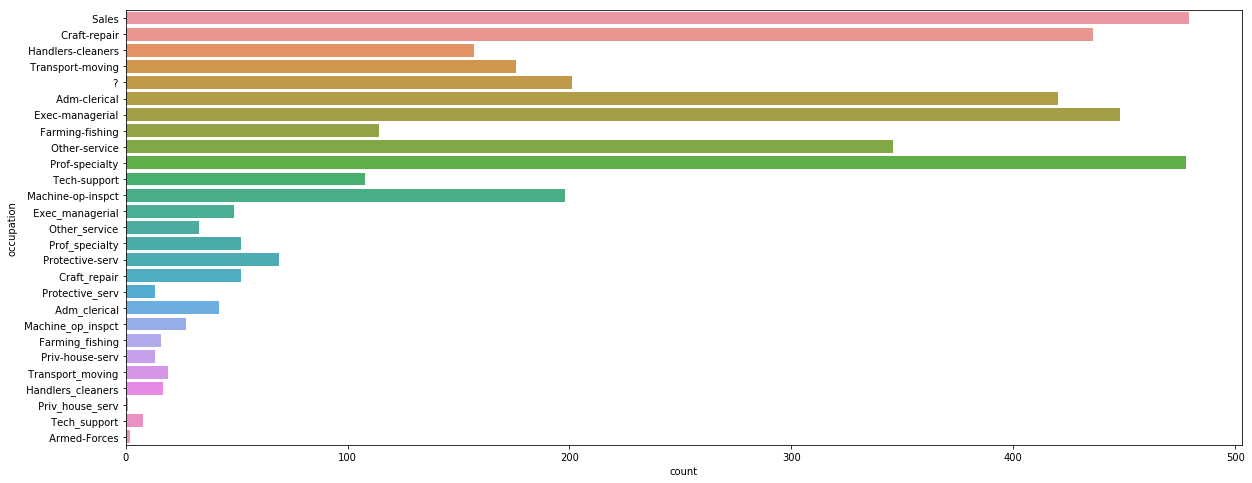

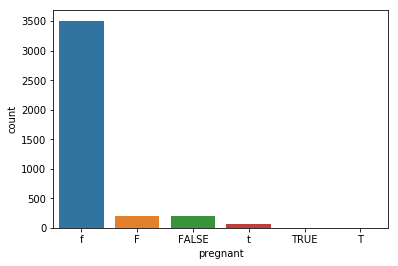

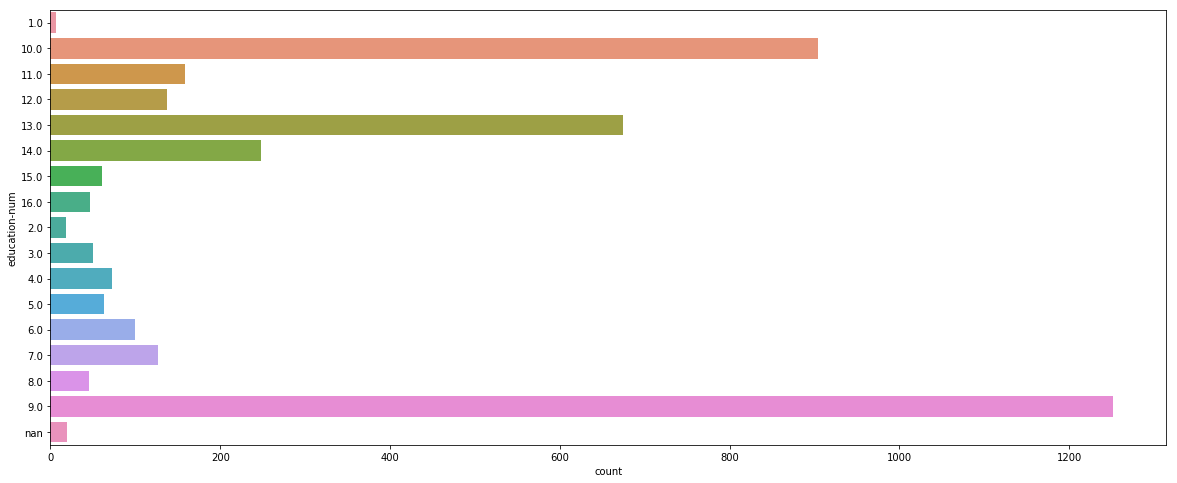

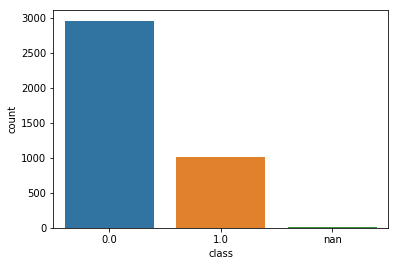

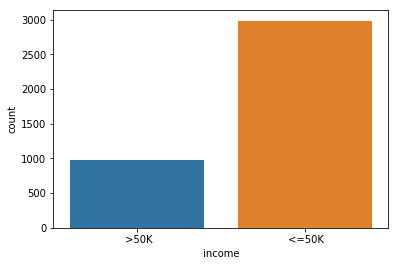

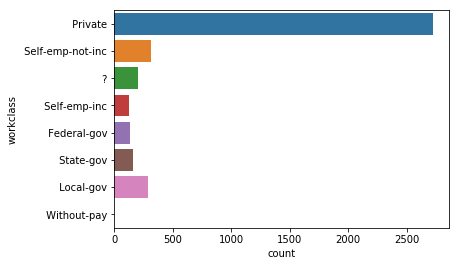

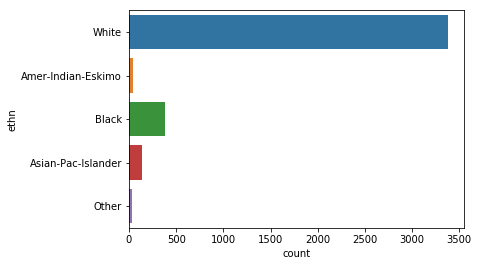

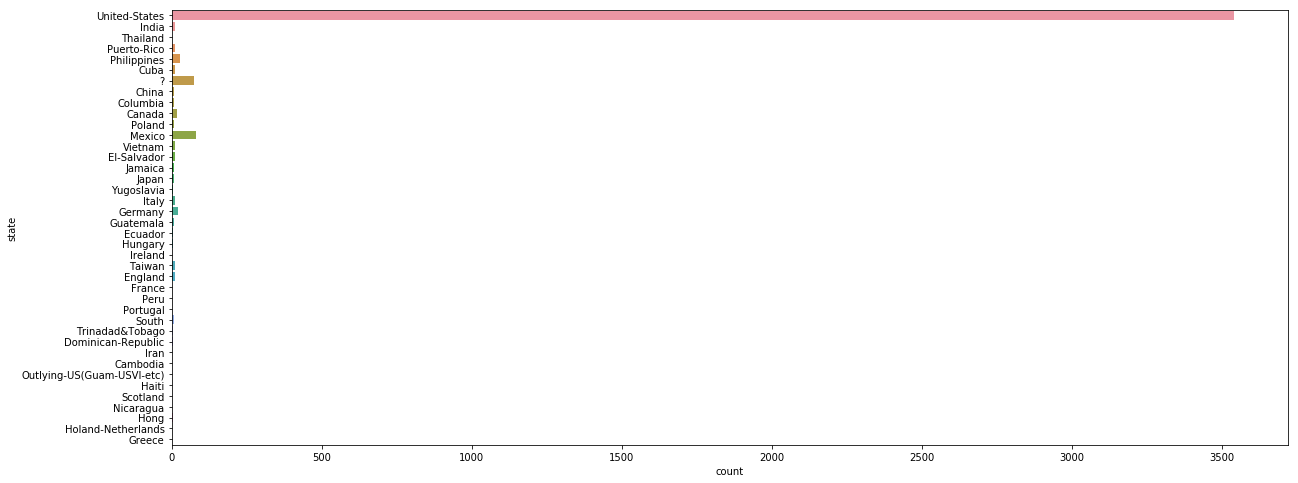

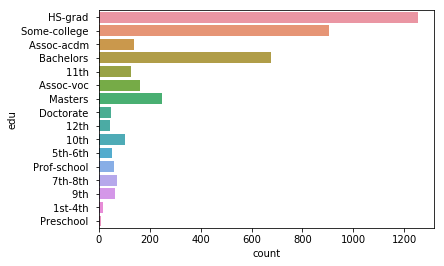

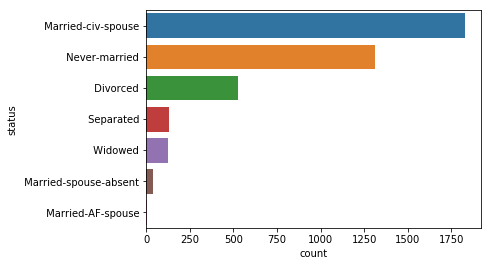

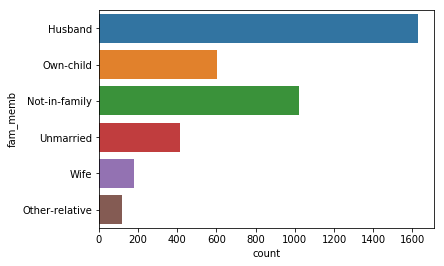

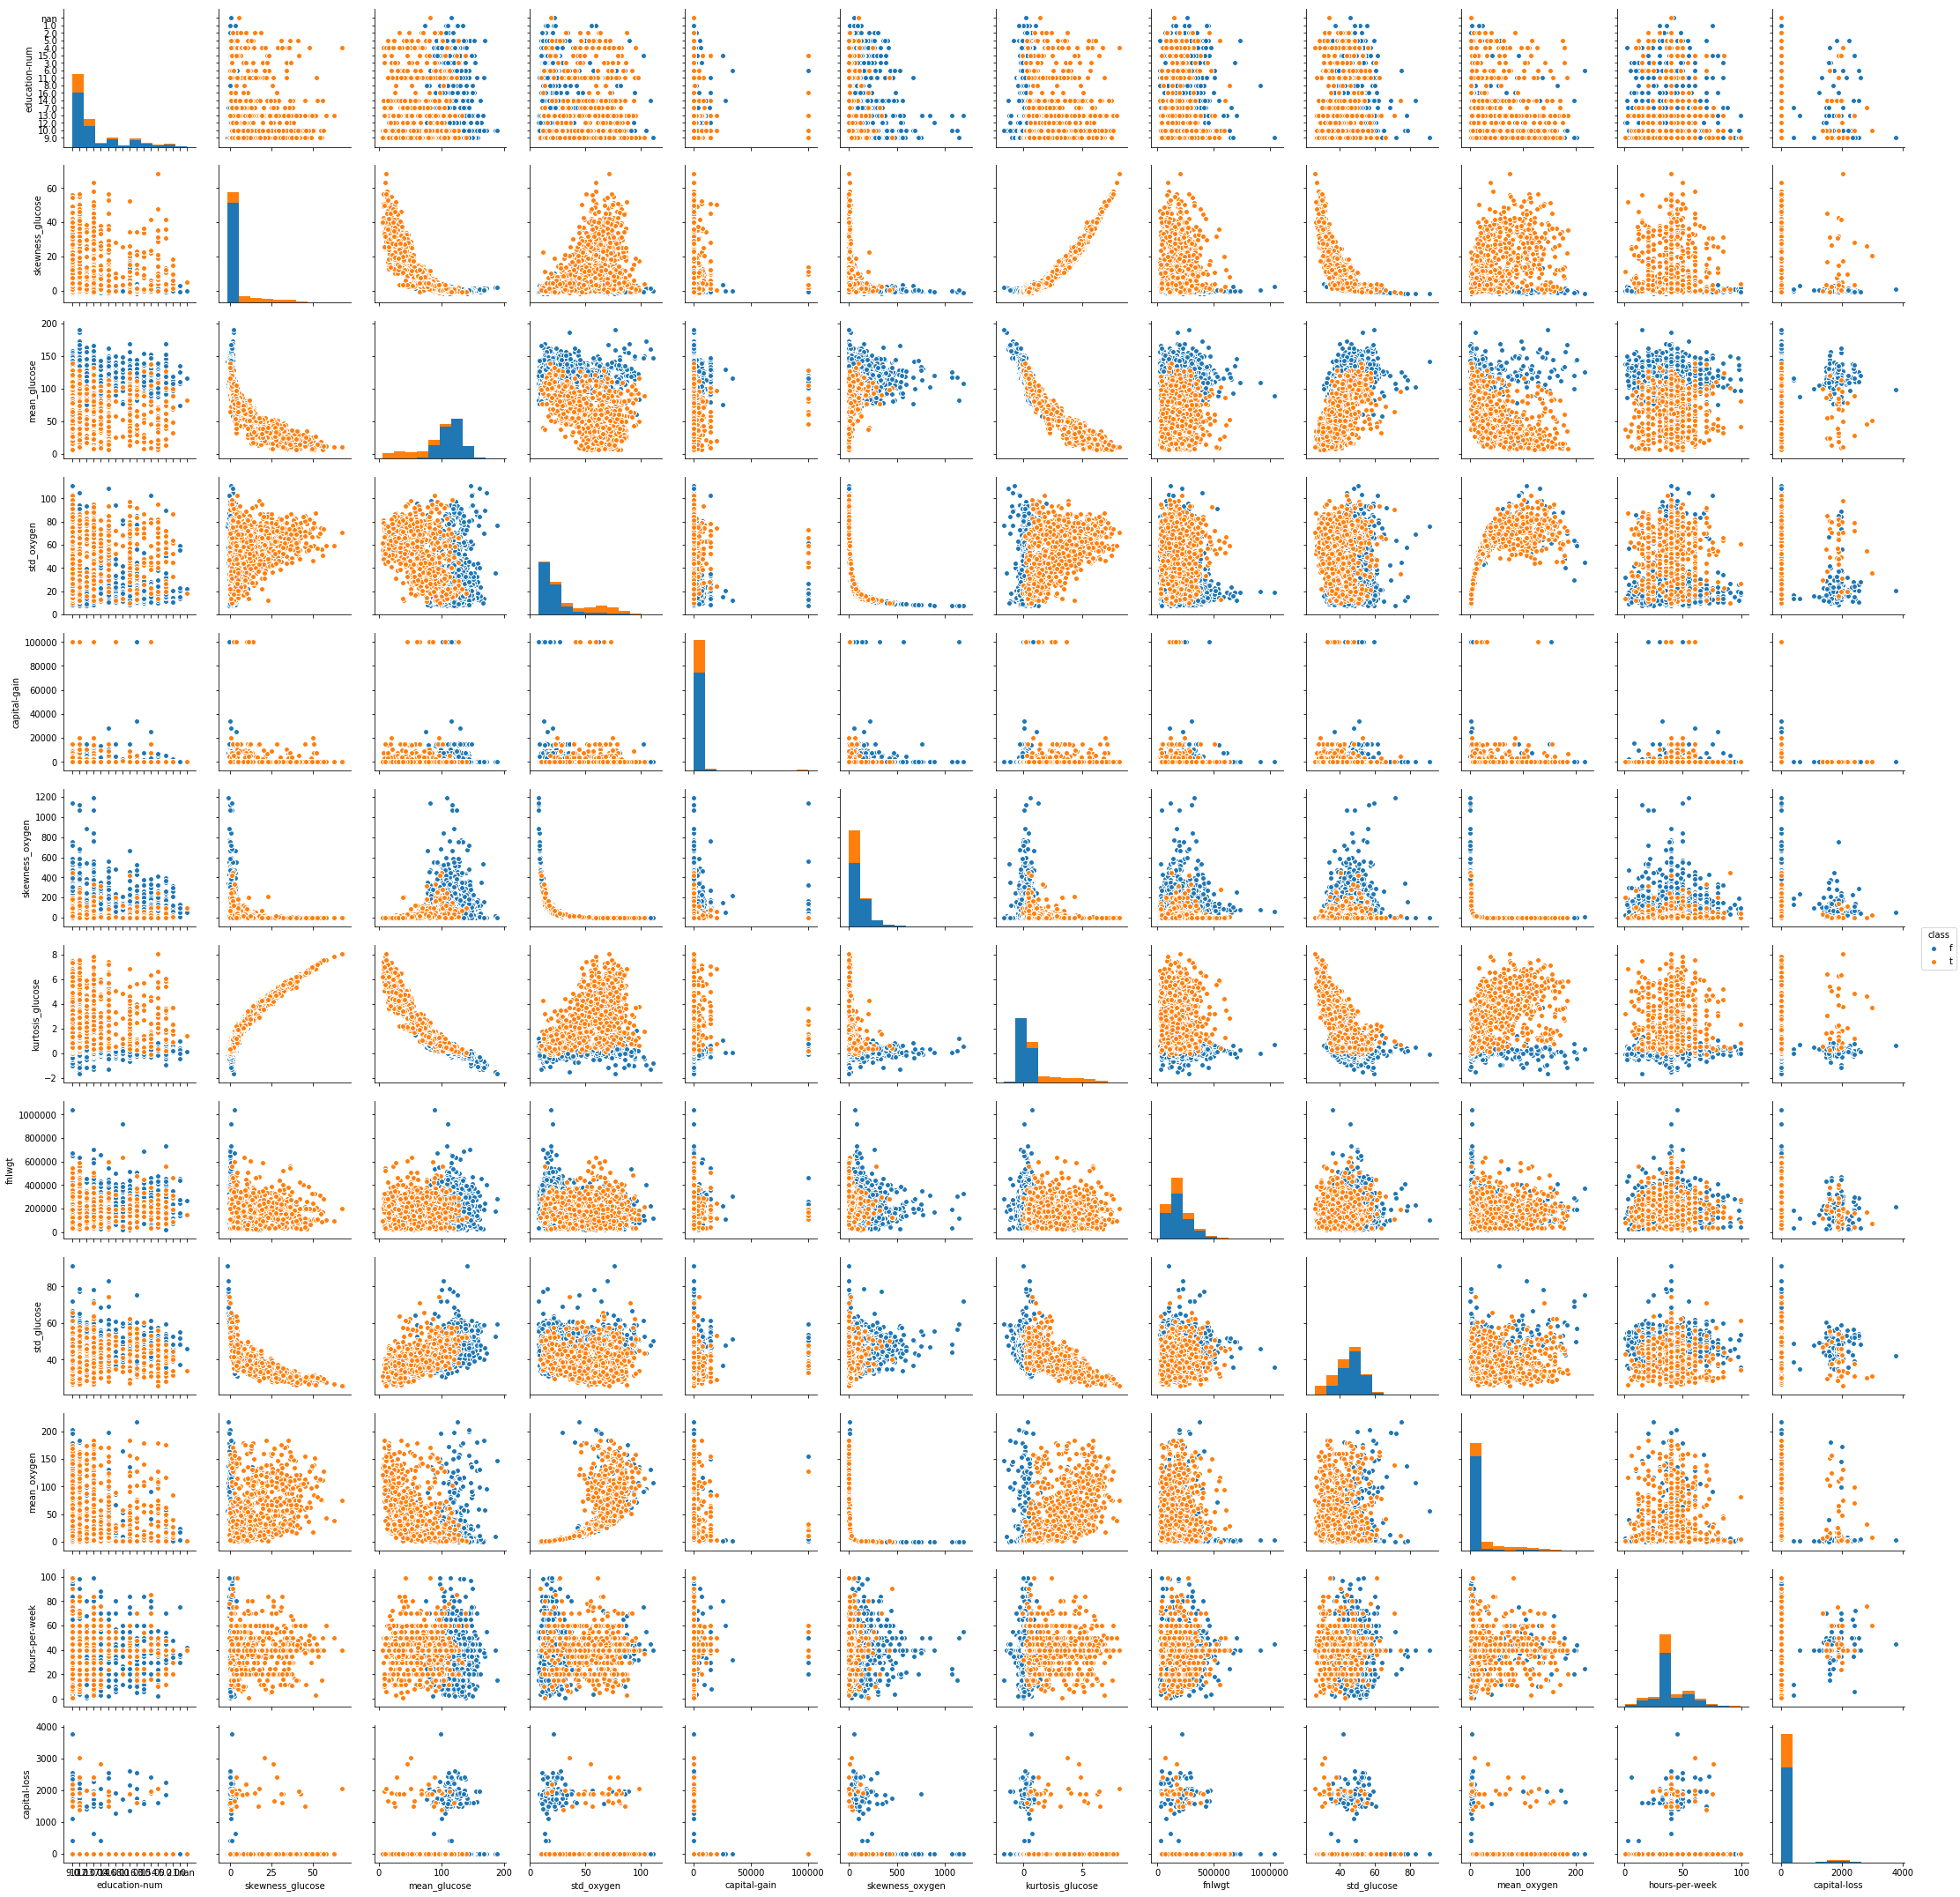

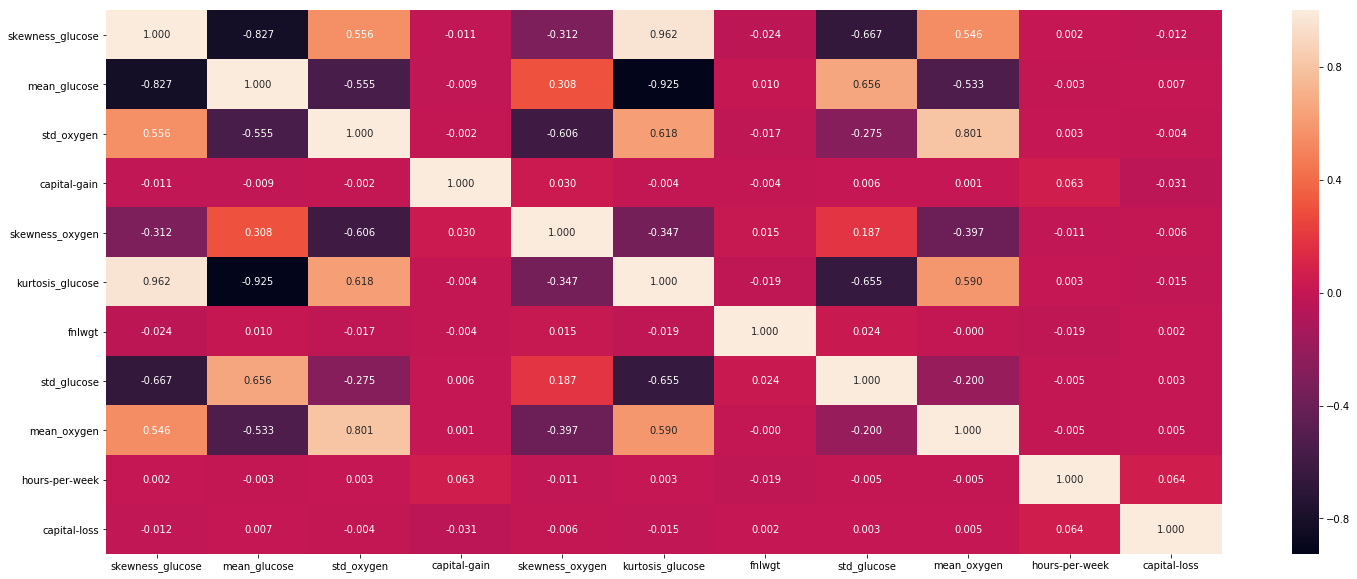

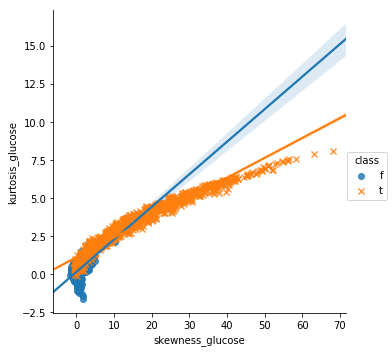

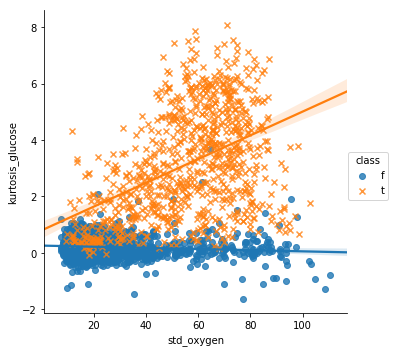

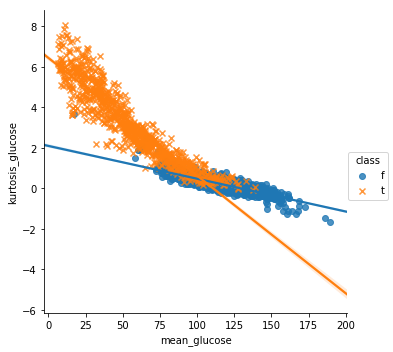

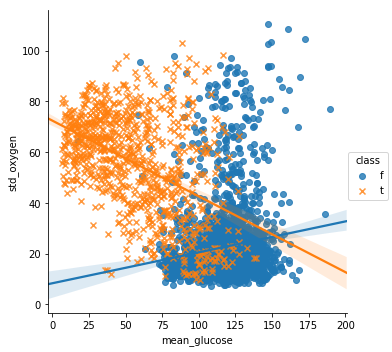

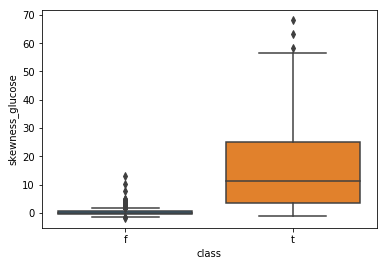

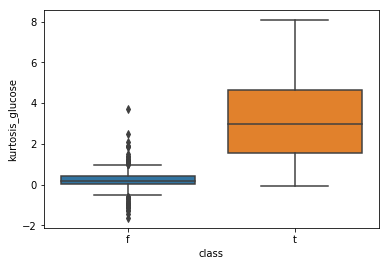

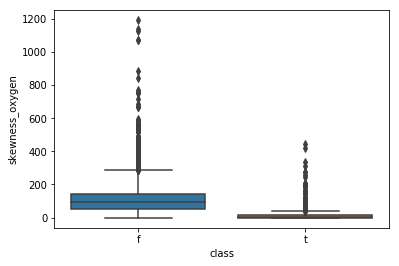

C:\Users\adria\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


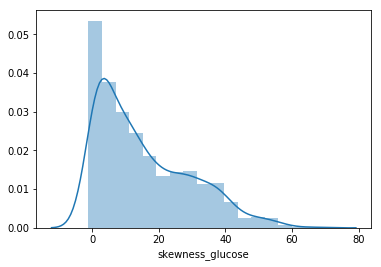

C:\Users\adria\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


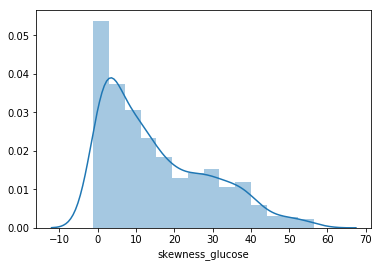

C:\Users\adria\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


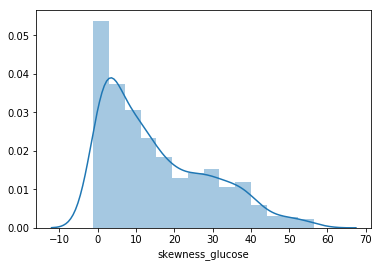

C:\Users\adria\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


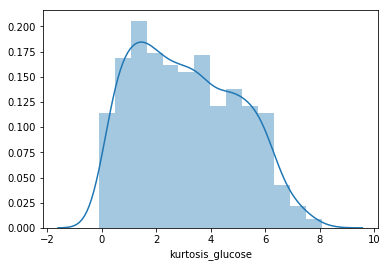

C:\Users\adria\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


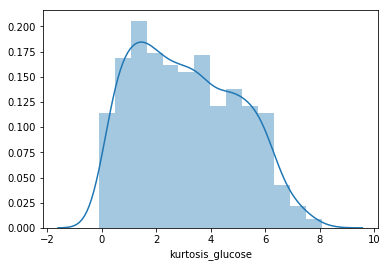

C:\Users\adria\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


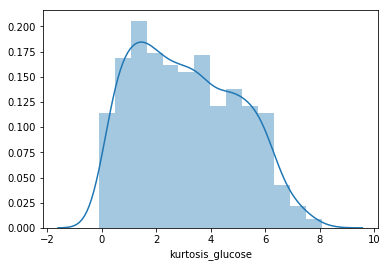

In [2]:
%run Projekt.ipynb

In [3]:
dataP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 5 columns):
name             3933 non-null object
address          3933 non-null object
age              3933 non-null int64
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: int64(1), object(4)
memory usage: 184.4+ KB


In [4]:
dataO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 26 columns):
name                3983 non-null object
address             3983 non-null object
kurtosis_oxygen     3709 non-null object
occupation          3974 non-null object
pregnant            3967 non-null object
education-num       3983 non-null object
skewness_glucose    3970 non-null float64
mean_glucose        3573 non-null float64
std_oxygen          3967 non-null float64
capital-gain        3970 non-null float64
skewness_oxygen     3969 non-null float64
kurtosis_glucose    3965 non-null float64
personal_info       3968 non-null object
fnlwgt              3974 non-null float64
class               3983 non-null object
std_glucose         3964 non-null float64
income              3967 non-null object
mean_oxygen         3971 non-null float64
hours-per-week      3969 non-null float64
capital-loss        3971 non-null float64
workclass           3961 non-null object
ethn                3

In [5]:
len(dataO.name.unique())

3933

In [6]:
namesO = dataO["name"].unique().sort()

In [7]:
namesP = dataP["name"].unique().sort()

In [8]:
np.array_equal(namesO, namesP)

True

In [9]:
dataO.head()

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",10.58036423,Sales,f,9.0,3.158830,85.859375,14.121127,0.0,...,>50K,1.857860,40.0,1902.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",3.713364594,Craft-repair,f,9.0,1.234184,91.679688,36.946291,0.0,...,<=50K,10.001672,40.0,2002.0,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",6.478064004,Handlers-cleaners,f,9.0,1.872355,89.960938,22.646980,0.0,...,<=50K,4.134615,48.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,10.0,0.395583,NaN,14.001759,0.0,...,>50K,1.849498,40.0,0.0,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,9.0,0.493384,94.593750,29.361953,0.0,...,<=50K,5.739130,40.0,0.0,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband


In [10]:
    dataOtypes = dataO["kurtosis_oxygen"].str.isdecimal()

In [11]:
dataOtypes.shape

(3983,)

In [12]:
dataOtypes.head()

0    False
1    False
2    False
3    False
4      NaN
Name: kurtosis_oxygen, dtype: object

In [13]:
duplNames = dataO[dataO['name'].duplicated(keep=False)]
duplNames.sort_values('name')

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
3718,Andrew Lawson,57159 Christopher Throughway Apt. 388\r\nWest ...,10.56049223,NaN,f,nan,2.486716,87.585938,16.756233,0.0,...,>50K,2.035117,40.0,0.0,NaN,White,United-States,Bachelors,Married-civ-spouse,Husband
1298,Andrew Lawson,57159 Christopher Throughway Apt. 388\r\nWest ...,10.56049223,Sales,f,13.0,2.486716,87.585938,16.756233,NaN,...,NaN,2.035117,40.0,0.0,Private,White,United-States,Bachelors,Married-civ-spouse,Husband
3402,Andrew Olmstead,"519 Christopher Loop Suite 282\r\nRachelside, ...",6.9289193560000015,Craft-repair,f,9.0,0.548669,NaN,26.559749,0.0,...,<=50K,4.382943,52.0,0.0,NaN,White,United-States,HS-grad,Married-civ-spouse,Husband
281,Andrew Olmstead,"519 Christopher Loop Suite 282\r\nRachelside, ...",6.9289193560000015,NaN,f,nan,0.548669,NaN,26.559749,0.0,...,<=50K,4.382943,52.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3851,Antonio Bailey,"29028 Bowman Parkways\r\nKerrview, FL 57851",0.368701087,Sales,f,6.0,10.093518,57.312500,79.734804,0.0,...,<=50K,96.128763,40.0,NaN,Self-emp-inc,White,Canada,10th,Widowed,Unmarried
2222,Antonio Bailey,"29028 Bowman Parkways\r\nKerrview, FL 57851",0.368701087,Sales,NaN,nan,10.093518,57.312500,79.734804,NaN,...,<=50K,NaN,40.0,0.0,Self-emp-inc,White,Canada,10th,Widowed,Unmarried
2606,Antonio Rowan,"016 Jacob Tunnel Apt. 031\r\nAmandabury, CA 37683",??,Handlers-cleaners,f,9.0,0.208850,128.968750,15.056887,0.0,...,NaN,1.887960,45.0,0.0,Private,NaN,NaN,NaN,NaN,NaN
1987,Antonio Rowan,"016 Jacob Tunnel Apt. 031\r\nAmandabury, CA 37683",??,Handlers-cleaners,NaN,9.0,0.208850,128.968750,15.056887,0.0,...,<=50K,1.887960,45.0,0.0,Private,Black,United-States,HS-grad,Separated,Unmarried
3947,Ben Nelson,"45315 Obrien Inlet\r\nCynthiaport, OH 63603",22.14937084,Transport-moving,f,9.0,1.137467,92.804688,9.089983,0.0,...,>50K,0.511706,40.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
956,Ben Nelson,"45315 Obrien Inlet\r\nCynthiaport, OH 63603",22.14937084,Transport-moving,f,9.0,NaN,NaN,NaN,0.0,...,>50K,0.511706,40.0,0.0,Private,NaN,NaN,NaN,NaN,NaN


Po vypísani duplicitných mien sme zistili, že zlúčením týchto duplikátov vieme vyplniť chýbajúce hodnoty. Zároveň hodnoty, ktoré majú oba duplikáty sú rovnaké. 

In [14]:
def fusionDuplicates(datasetO):
    duplicat = datasetO[datasetO['name'].duplicated(keep=False)]
    duplicat = duplicat.sort_values('name')
    duplicat = duplicat.reset_index(drop=True)
    
    for i, row in duplicat.iterrows():
        if(i%2==1):
            duplicat = duplicat.drop(i)
            continue
        for j, value in row.items():
            dupValue = duplicat.loc[i+1,j]
            if(pd.isna(value)):
                duplicat.loc[i,j]=dupValue
    datasetO.drop_duplicates(subset='name',keep=False,inplace=True)
    result = datasetO.append(duplicat, ignore_index=True)
    return(result)

In [15]:
dataO=fusionDuplicates(dataO)
dataO

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",10.58036423,Sales,f,9.0,3.158830,85.859375,14.121127,0.0,...,>50K,1.857860,40.0,1902.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",3.713364594,Craft-repair,f,9.0,1.234184,91.679688,36.946291,0.0,...,<=50K,10.001672,40.0,2002.0,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",6.478064004,Handlers-cleaners,f,9.0,1.872355,89.960938,22.646980,0.0,...,<=50K,4.134615,48.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,10.0,0.395583,NaN,14.001759,0.0,...,>50K,1.849498,40.0,0.0,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,9.0,0.493384,94.593750,29.361953,0.0,...,<=50K,5.739130,40.0,0.0,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband
5,Todd Flanagan,"2167 Wells Shoals Apt. 264\r\nEast Brianshire,...",6.384963147000001,?,f,9.0,-0.303185,125.742188,29.664529,0.0,...,<=50K,4.951505,15.0,0.0,?,White,United-States,HS-grad,Married-civ-spouse,Own-child
6,James Huffman,"535 Michael Squares\r\nNorth Sara, ID 61368",8.938092965,Sales,f,10.0,0.091356,145.835938,19.440728,0.0,...,<=50K,2.637124,50.0,0.0,Private,White,United-States,Some-college,Divorced,Not-in-family
7,Gary Prentice,"055 Nolan Club\r\nWest Bryanton, UT 15308",5.155939859,?,f,12.0,0.046797,138.179688,31.576347,0.0,...,<=50K,6.330268,1.0,0.0,?,White,United-States,Assoc-acdm,Divorced,Unmarried
8,Rodger Riis,7719 Frances Drives Apt. 525\r\nWest Brandonst...,2.436555082,Sales,f,10.0,-0.797075,129.976562,56.661158,0.0,...,<=50K,22.038462,35.0,0.0,Self-emp-inc,White,United-States,Some-college,Never-married,Own-child
9,Robert Cabiness,"70838 Robbins Camp Suite 853\r\nJacobville, SC...",14.38934822,Sales,f,9.0,1.035747,107.578125,11.797305,0.0,...,<=50K,1.002508,40.0,0.0,Private,White,United-States,HS-grad,Never-married,Own-child


In [16]:
dataO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 26 columns):
name                3933 non-null object
address             3933 non-null object
kurtosis_oxygen     3677 non-null object
occupation          3933 non-null object
pregnant            3933 non-null object
education-num       3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
personal_info       3932 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null object
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3931 non-null object
ethn                3

In [17]:
dataO[dataO.isnull().any(axis=1)]

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,10.0,0.395583,NaN,14.001759,0.0,...,>50K,1.849498,40.0,0.0,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,9.0,0.493384,94.593750,29.361953,0.0,...,<=50K,5.739130,40.0,0.0,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband
12,Thomas Rathburn,"708 Rodgers Streets Suite 909\r\nVanessamouth,...",8.620895914,Craft-repair,f,9.0,-0.685681,NaN,19.802528,0.0,...,<=50K,2.981605,40.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
30,Patrick Cortez,"96216 Prince Prairie\r\nSouth Ryantown, IL 02827",7.1463000810000015,Exec-managerial,f,14.0,-0.036529,NaN,25.228435,0.0,...,<=50K,3.768395,45.0,0.0,Local-gov,White,United-States,Masters,Married-civ-spouse,Husband
56,Bobby Alicea,"787 Edwards Groves\r\nNew Melissaville, VT 70198",9.805805146,Exec-managerial,f,13.0,0.137797,NaN,18.641943,0.0,...,>50K,2.074415,40.0,0.0,Private,White,United-States,Bachelors,Married-civ-spouse,Husband
63,Kendrick Presha,9027 Odom Turnpike Suite 930\r\nLake Mariebury...,NaN,Other-service,f,7.0,2.432726,90.304688,12.879898,0.0,...,<=50K,2.207358,15.0,0.0,Private,White,United-States,11th,Never-married,Own-child
68,Fredrick Jack,"610 Griffith Causeway Apt. 479\r\nMatthewside,...",NaN,Machine-op-inspct,f,9.0,38.708198,7.796875,55.704857,0.0,...,<=50K,109.125418,20.0,0.0,Private,White,United-States,HS-grad,Never-married,Own-child
71,James Bonner,"09320 Smith Trace Apt. 263\r\nAllenfort, MI 15391",NaN,Machine-op-inspct,f,10.0,-0.551288,119.960938,12.605750,0.0,...,<=50K,1.769231,45.0,0.0,Private,White,United-States,Some-college,Married-civ-spouse,Husband
75,Mark Barrera,"18561 Scott Orchard Apt. 325\r\nDavismouth, MT...",9.233192137,Handlers-cleaners,f,9.0,0.146675,NaN,14.620565,0.0,...,<=50K,2.423913,20.0,0.0,Private,White,United-States,HS-grad,Divorced,Own-child
76,Thomas Bohler,"0168 Linda Pine Suite 684\r\nSouth Adamside, A...",??,Prof-specialty,FALSE,12.0,0.476484,NaN,14.197757,0.0,...,<=50K,1.751672,36.0,0.0,State-gov,Asian-Pac-Islander,United-States,Assoc-acdm,Divorced,Unmarried


In [18]:
replaced = dataO.replace(to_replace=r'^[0-9,\-].*[0-9]$',value='number',regex=True)
replaced.select_dtypes(include='object')

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,personal_info,class,income,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",number,Sales,f,number,White|United-States\r\r\nHS-grad -- Married-ci...,f,>50K,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",number,Craft-repair,f,number,White|United-States\r\r\nHS-grad -- Married-ci...,f,<=50K,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",number,Handlers-cleaners,f,number,White|United-States\r\r\nHS-grad -- Married-ci...,f,<=50K,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,number,White|United-States\r\r\nSome-college -- Marri...,f,>50K,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,number,Amer-Indian-Eskimo|United-States\r\r\nHS-grad ...,f,<=50K,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband
5,Todd Flanagan,"2167 Wells Shoals Apt. 264\r\nEast Brianshire,...",number,?,f,number,White|United-States\r\r\nHS-grad -- Married-ci...,f,<=50K,?,White,United-States,HS-grad,Married-civ-spouse,Own-child
6,James Huffman,"535 Michael Squares\r\nNorth Sara, ID 61368",number,Sales,f,number,White|United-States\r\r\nSome-college -- Divor...,f,<=50K,Private,White,United-States,Some-college,Divorced,Not-in-family
7,Gary Prentice,"055 Nolan Club\r\nWest Bryanton, UT 15308",number,?,f,number,White|United-States\r\r\nAssoc-acdm -- Divorce...,f,<=50K,?,White,United-States,Assoc-acdm,Divorced,Unmarried
8,Rodger Riis,7719 Frances Drives Apt. 525\r\nWest Brandonst...,number,Sales,f,number,White|United-States\r\r\nSome-college -- Never...,f,<=50K,Self-emp-inc,White,United-States,Some-college,Never-married,Own-child
9,Robert Cabiness,"70838 Robbins Camp Suite 853\r\nJacobville, SC...",number,Sales,f,number,White|United-States\r\r\nHS-grad -- Never-marr...,f,<=50K,Private,White,United-States,HS-grad,Never-married,Own-child


In [19]:
replaced['kurtosis_oxygen'].unique()

array(['number', '??', nan], dtype=object)

In [20]:
replaced['occupation'].unique()

array([' Sales', ' Craft-repair', ' Handlers-cleaners',
       ' Transport-moving', ' ?', ' Adm-clerical', ' Exec-managerial',
       ' Farming-fishing', ' Other-service', ' Prof-specialty',
       ' Tech-support', ' Machine-op-inspct', ' Exec_managerial',
       ' Other_service', ' Prof_specialty', ' Protective-serv',
       ' Craft_repair', ' Protective_serv', ' Adm_clerical',
       ' Machine_op_inspct', ' Farming_fishing', ' Priv-house-serv',
       ' Transport_moving', ' Handlers_cleaners', ' Priv_house_serv',
       ' Tech_support', ' Armed-Forces'], dtype=object)

In [21]:
replaced['pregnant'].unique()

array(['f', 'F', 'FALSE', 't', 'TRUE', 'T'], dtype=object)

In [22]:
replaced['education-num'].unique()

array(['number', 'nan'], dtype=object)

In [23]:
replaced['edu'].unique()

array(['HS-grad ', 'Some-college ', 'Assoc-acdm ', 'Bachelors ', '11th ',
       'Assoc-voc ', 'Masters ', 'Doctorate ', '12th ', '10th ',
       '5th-6th ', 'Prof-school ', '7th-8th ', '9th ', '1st-4th ',
       'Preschool ', nan], dtype=object)

In [24]:
replaced['income'].unique()

array([' >50K', ' <=50K', nan], dtype=object)

In [25]:
replaced['workclass'].unique()

array([' Private', ' Self-emp-not-inc', ' ?', ' Self-emp-inc',
       ' Federal-gov', ' State-gov', ' Local-gov', ' Without-pay', nan],
      dtype=object)

In [26]:
replaced['ethn'].unique()

array(['White', 'Amer-Indian-Eskimo', 'Black', 'Asian-Pac-Islander',
       'Other', nan], dtype=object)

In [27]:
replaced['state'].unique()

array(['United-States', 'India', 'Thailand', 'Puerto-Rico', 'Philippines',
       'Cuba', '?', 'China', 'Columbia', 'Canada', 'Poland', 'Mexico',
       'Vietnam', 'El-Salvador', 'Jamaica', 'Japan', 'Yugoslavia',
       'Italy', 'Germany', 'Guatemala', 'Ecuador', 'Hungary', 'Ireland',
       'Taiwan', 'England', 'France', 'Peru', 'Portugal', 'South',
       'Trinadad&Tobago', 'Dominican-Republic', 'Iran', 'Cambodia',
       'Outlying-US(Guam-USVI-etc)', 'Haiti', 'Scotland', 'Nicaragua',
       'Hong', 'Holand-Netherlands', 'Greece', nan], dtype=object)

In [28]:
replaced['status'].unique()

array([' Married-civ-spouse', ' Divorced', ' Never-married', ' Separated',
       ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse', nan],
      dtype=object)

In [29]:
replaced['fam_memb'].unique()
replacet.

array(['Husband', 'Own-child', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative', nan], dtype=object)

In [32]:
def correctValuesO(dataset):
    for i, row in dataset.iterrows():
        for j, value in row.items():
            replValue = value.str.replace('_','-')
            dataset.loc[i,j]=replValue

In [33]:
correctValuesO(dataO)

AttributeError: 'str' object has no attribute 'str'